### Using *scaled* data
First I am importing necessary libraries, then importing data, removing the arbitrary index "Unnamed: 0" column, and viewing the first few observations for each.

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import backend as K
import sklearn
from sklearn.preprocessing import MinMaxScaler

In [146]:
train = pd.read_csv('data/red_wine_train.csv')
train.drop('Unnamed: 0',axis=1, inplace=True)
train.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality,alcohol_higher,va_high
0,7.0,0.685,0.00,0.067,63.0,0.99790,0.81,9.90,5,0,1
1,8.6,0.685,0.10,0.092,12.0,0.99745,0.65,9.55,6,0,1
2,5.6,0.660,0.00,0.087,11.0,0.99378,0.63,12.80,7,1,1
3,7.7,0.510,0.28,0.087,54.0,0.99800,0.74,9.20,5,0,0
4,8.7,0.310,0.46,0.059,25.0,0.99660,0.76,10.10,6,0,0


In [147]:
test = pd.read_csv('data/red_wine_test.csv')
test.drop('Unnamed: 0',axis=1, inplace=True)
test.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality,alcohol_higher,va_high
0,12.6,0.310,0.72,0.072,29.0,0.99870,0.82,9.8,8,0,0
1,11.8,0.330,0.49,0.093,80.0,1.00020,0.76,10.7,7,0,0
2,7.1,0.875,0.05,0.082,14.0,0.99808,0.52,10.2,3,0,1
3,9.0,0.800,0.12,0.083,28.0,0.99836,0.65,10.4,6,0,1
4,7.9,0.690,0.21,0.080,141.0,0.99620,0.51,9.9,5,0,1


To decide how to scale each attribute, I am viewing the statistical summary of each column with describe(). Some columns already range from 0 to 1 while others have maximums above 10 or for total sulfur dioxide, almost 300. To ensure the neural network performs ideally, I am going to scale each column to [0,1] using the Min-Max Normalization method through scikitlearn's MinMaxScaler. Since we already split the data into test and train sets, I am first going to recombine these two disjoint dataframes back into one dataframe so that my values for mins and maxes needed for the formula are constant across scaling each of the two dataframes--it is likely that test and/or train contains a unique min or max value, and if we performed the min and max fit on these dfs separately, the values would not be the same (if one had a lower max for example) and our scaling would be flawed. This way, two equal values will certainly be transformed to the same value whether or not they begin in test or in train.

As mentioned, first we concatenate test and train back into one dataframe. Next we use .describe() to view summary of each column. Then we make a histogram of the 'quality' column to see what kind of imbalance we are working with. 

In [148]:
#recombining train & test to get overall max and min values so test and train are scaled w same values in the scaler
whole_set = pd.concat([train,test])

#make variable for each quality column
qual3 = (whole_set[whole_set["quality"]==3])
qual4 = (whole_set[whole_set["quality"]==4]) 
qual5 = (whole_set[whole_set["quality"]==5]) 
qual6 = (whole_set[whole_set["quality"]==6])
qual7 = (whole_set[whole_set["quality"]==7])
qual8 = (whole_set[whole_set["quality"]==8])

#number of samples per class label to determine inbalance
n_qual3 = len(qual3) #10
n_qual4 = len(qual4) #53
n_qual5 = len(qual5) #681
n_qual6 = len(qual6) #638
n_qual7 = len(qual7) #199
n_qual8 = len(qual8) #18

#make each column a numpy array for class weights computation
qual3_numpy = qual3['quality'].to_numpy()
qual4_numpy = qual4['quality'].to_numpy()
qual5_numpy = qual5['quality'].to_numpy()
qual6_numpy = qual6['quality'].to_numpy()
qual7_numpy = qual7['quality'].to_numpy()
qual8_numpy = qual8['quality'].to_numpy()

#combine numpy arrays into whole numpy and set variable for class values
whole_numpy = np.concatenate((qual3_numpy, qual4_numpy, qual5_numpy, qual6_numpy, qual7_numpy, qual8_numpy))
unique_classes = np.unique(whole_numpy)

#compute weights with sklearn method
weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=unique_classes, y=whole_numpy)
weights_dict = {i:w for i,w in enumerate(weights)}

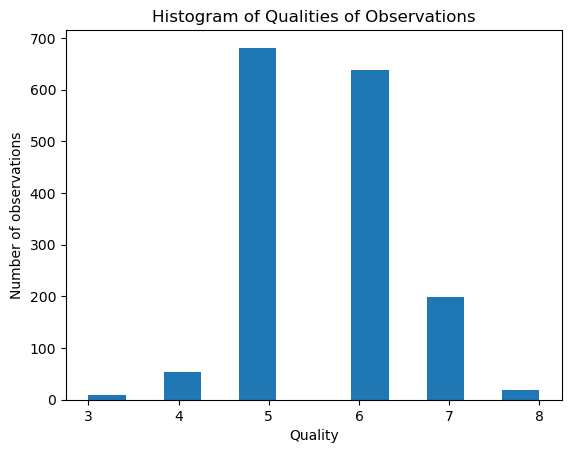

In [149]:
whole_set.describe() #summary to understand all columns have varying scales

#plot to show imbalanced data
plt.hist(whole_set['quality'], bins=12)
plt.title("Histogram of Qualities of Observations")
plt.ylabel('Number of observations')
plt.xlabel('Quality')
plt.show()

Here, we fit the scaler before using it to transform both train and test dfs.

From our scaled data frames, we will separate each into dataframes of attributes only and class label 'quality' only. Additionally we put the number of attributes into a variable n_inputs to be used as a parameter in the model.

In [150]:
#####
#drop quality class label column before scaling
whole_set.drop('quality',axis=1, inplace=True)

#build scaler
scaler = MinMaxScaler() #build scaler
scaler.fit(whole_set) #fit scaler to entire df

#####drop quality
trainAttr = train.drop('quality',axis=1) #training df without class column

testAttr = test.drop('quality',axis=1) #training df without class column

trainClassAttr = train['quality'] #training df only class column

testClassAttr = test['quality'] #testing df only class column

trainClassAttr = trainClassAttr.map({3:0, 4:1, 5:2, 6:3, 7:4, 8:5})
testClassAttr = testClassAttr.map({3:0, 4:1, 5:2, 6:3, 7:4, 8:5})

#transform train and test separately, both using same scaler fit from whole df
train_scaled=scaler.transform(trainAttr)
test_scaled=scaler.transform(testAttr)

#make transformed data in a dataframe (.transform returns arrays, we want df) using old col names
train_scaled = pd.DataFrame(train_scaled, columns=trainAttr.columns)
test_scaled = pd.DataFrame(test_scaled, columns=testAttr.columns)

####variable for input
n_inputs = [trainAttr.shape[1]] #10 attributes = 10 input nodes

<AxesSubplot:>

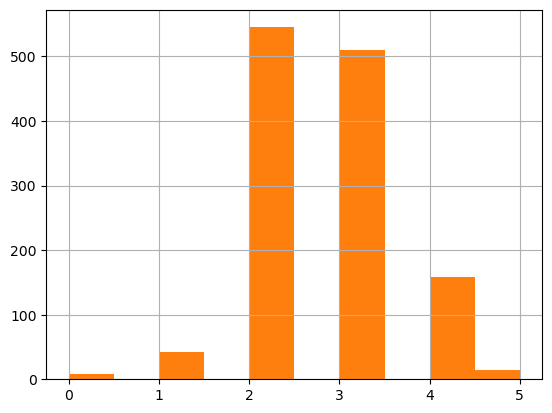

In [151]:
#plot each class column (train and test) to see how imbalance compares
testClassAttr.hist()
trainClassAttr.hist()

Next we build, summarize, and compile the model.

In [152]:
#modelScaled = tf.keras.Sequential([tf.keras.layers.Dense(units=1,input_shape=n_inputs)]) #build model with one layer
#modelScaled.summary()



modelScaled = tf.keras.Sequential([
 
    tf.keras.layers.Dense(units=64, activation='relu',
                          input_shape=n_inputs),
    tf.keras.layers.Dense(units=6, activation='softmax')
])

modelScaled.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 64)                704       
                                                                 
 dense_58 (Dense)            (None, 6)                 390       
                                                                 
Total params: 1,094
Trainable params: 1,094
Non-trainable params: 0
_________________________________________________________________


In [153]:
modelScaled.compile(optimizer='adam',
              loss='mae',
              metrics=['accuracy'])

#K.set_value(modelScaled.optimizer.learning_rate, 0.1)

Finally we fit the model and view the accuracy outputs at each epoch.

In [154]:
modelScaled.fit(train_scaled, trainClassAttr, epochs=5)

Epoch 1/5
40/40 [==============================] - 1s 3ms/step - loss: 2.4726 - accuracy: 0.0594
Epoch 2/5
40/40 [==============================] - 0s 3ms/step - loss: 2.4726 - accuracy: 0.0594
Epoch 3/5
40/40 [==============================] - 0s 3ms/step - loss: 2.4726 - accuracy: 0.0594
Epoch 4/5
40/40 [==============================] - 0s 3ms/step - loss: 2.4726 - accuracy: 0.0594
Epoch 5/5
40/40 [==============================] - 0s 3ms/step - loss: 2.4726 - accuracy: 0.0594


In [155]:
modelScaled.fit(train_scaled, trainClassAttr,
 
                   validation_data=(test_scaled, testClassAttr),
                    class_weight=weights_dict,
                    
                   # it will use 'batch_size' number
                   # of examples per example
                   batch_size=50,
                   epochs=5,  # total epoch
 
                   )

Epoch 1/5
26/26 [==============================] - 1s 18ms/step - loss: 2.4205 - accuracy: 0.0594 - val_loss: 2.4667 - val_accuracy: 0.0562
Epoch 2/5
26/26 [==============================] - 0s 6ms/step - loss: 2.4205 - accuracy: 0.0594 - val_loss: 2.4667 - val_accuracy: 0.0562
Epoch 3/5
26/26 [==============================] - 0s 7ms/step - loss: 2.4205 - accuracy: 0.0594 - val_loss: 2.4667 - val_accuracy: 0.0562
Epoch 4/5
26/26 [==============================] - 0s 6ms/step - loss: 2.4205 - accuracy: 0.0594 - val_loss: 2.4667 - val_accuracy: 0.0562
Epoch 5/5
26/26 [==============================] - 0s 6ms/step - loss: 2.4205 - accuracy: 0.0594 - val_loss: 2.4667 - val_accuracy: 0.0562
